In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/EVA5_Session10

/content/drive/My Drive/EVA5_Session10


In [3]:
!ls

cifar10    dataset_file.py  lr_finder.py      __pycache__
config.py  engine.py	    models	      save_load.py
cuda.py    gradcam	    preprocessing.py  utils.py


In [4]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 4.5MB/s 
     |████████████████████████████████| 952kB 13.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=684f85ce8692f29c0e01a3b732dba9f34d26f242d55015818440b093d9838d6d
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [5]:
%reload_ext autoreload
%autoreload 2

In [12]:
import torch
import torchvision
import os
import utils
import dataset_file as dataset
import engine
from models import resnet
import config
import torchvision.datasets as datasets
import cuda
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import albumentations as A
import save_load
import matplotlib.pyplot as plt
from gradcam import GradCAMView
from lr_finder import LRFinder

In [13]:
cuda, device = cuda.initialize_cuda(config.SEED)

GPU Available? True


In [14]:
trainset = dataset.torch_datasets(True, True, dataset_name='cifar10')
testset = dataset.torch_datasets(False, True, dataset_name='cifar10')

Files already downloaded and verified
Files already downloaded and verified


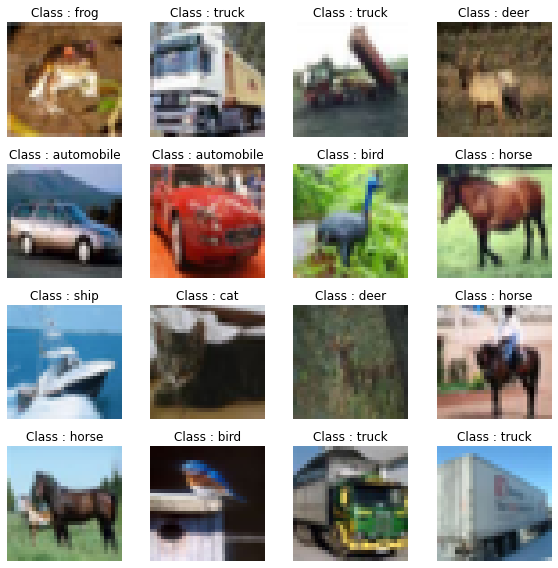

In [15]:
utils.show_imgs(trainset, 16, (8, 8))

In [16]:
mean, std = utils.get_stats(trainset)[0], utils.get_stats(trainset)[1]
print(mean, std)

(0.4914, 0.4822, 0.4465) (0.247, 0.2435, 0.2616)


In [17]:
transformations_list = [A.Normalize(mean, std)]
augmentations_list = [A.Rotate(15), 
                      A.HorizontalFlip(),
                      A.Cutout(1, 16, 16, fill_value=mean, p=0.3)]

In [18]:
trainset = dataset.torch_datasets(True, True, transformations_list, augmentations_list, dataset_name='cifar10')
testset = dataset.torch_datasets(False, True, transformations_list, dataset_name='cifar10')
train_dl = dataset.data_loader(trainset, config.BATCH_SIZE, config.NUM_WORKERS, cuda, shuffle=True)
test_dl = dataset.data_loader(testset, config.BATCH_SIZE, config.NUM_WORKERS, cuda, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


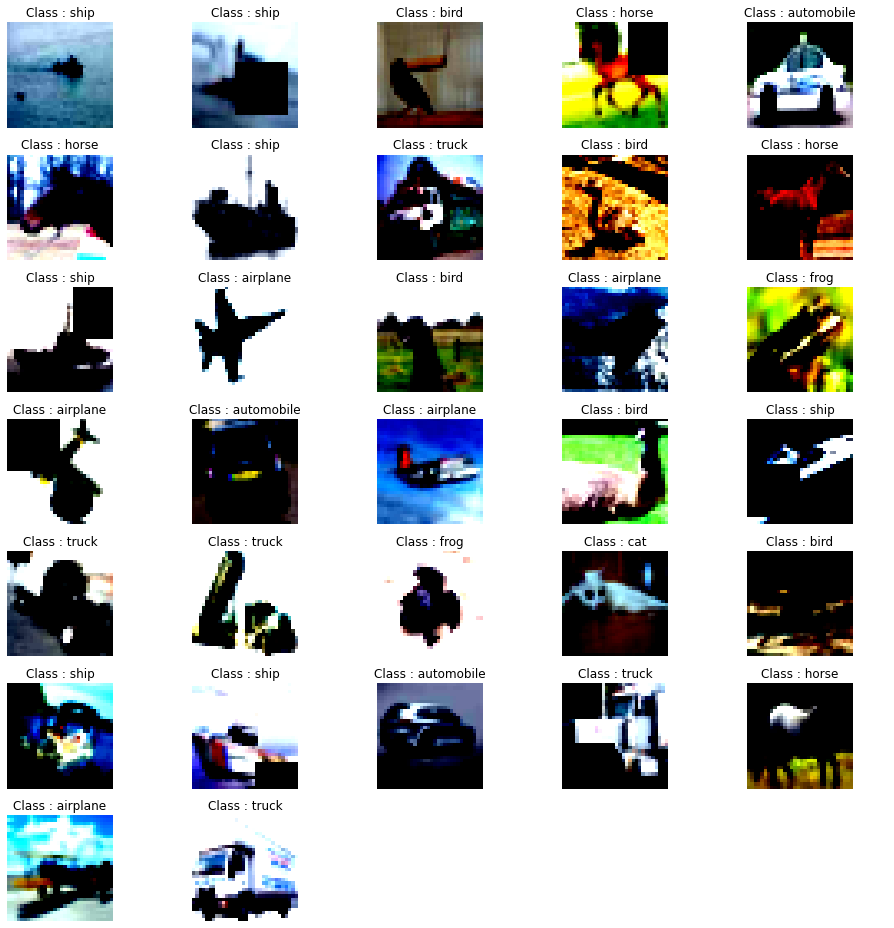

In [19]:
utils.show_batch(train_dl, (13, 13))

In [20]:
model = resnet.ResNet18().to(device)

In [21]:
utils.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [22]:
model = resnet.ResNet18().to(device)
loss_fn = utils.cross_entropy_loss_fn()
optimizer = utils.sgd_optimizer(model, lr=0.0001)
lr_finder = LRFinder(model, optimizer, loss_fn, device)

In [23]:
lr_finder.range_test(train_dl, start_lr=0.0001, end_lr=1, num_iter=200, step_mode='linear')


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.96E-01


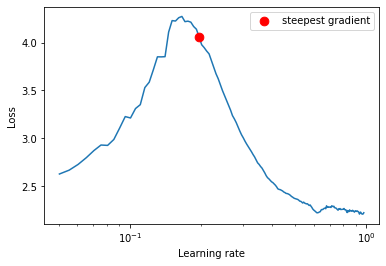

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3e1bf907f0>,
 0.19606030150753767)

In [24]:
lr_finder.plot()

In [25]:
config.EPOCHS = 50

In [26]:
model = resnet.ResNet18().to(device)
loss_fn = utils.cross_entropy_loss_fn()
optimizer = utils.sgd_optimizer(model, lr=2.31E-01)
if config.DEBUG == True:
    config.EPOCHS = 30

scheduler = utils.LR_on_pleateau_scheduler(optimizer, patience=15)
test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{config.EPOCHS}\n")
    engine.train(model, train_dl, optimizer, loss_fn, device, train_losses, train_accuracy)
    engine.test(model, test_dl, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)
    scheduler.step(test_loss[epoch])

  0%|          | 0/1563 [00:00<?, ?it/s]

Running Epoch 1/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0550, Accuracy: 3613/10000 (36.13%)

Running Epoch 2/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0464, Accuracy: 4714/10000 (47.14%)

Running Epoch 3/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0395, Accuracy: 5563/10000 (55.63%)

Running Epoch 4/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0322, Accuracy: 6326/10000 (63.26%)

Running Epoch 5/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0268, Accuracy: 6983/10000 (69.83%)

Running Epoch 6/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0249, Accuracy: 7284/10000 (72.84%)

Running Epoch 7/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0255, Accuracy: 7316/10000 (73.16%)

Running Epoch 8/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0200, Accuracy: 7825/10000 (78.25%)

Running Epoch 9/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0186, Accuracy: 7993/10000 (79.93%)

Running Epoch 10/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0188, Accuracy: 7975/10000 (79.75%)

Running Epoch 11/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0199, Accuracy: 7944/10000 (79.44%)

Running Epoch 12/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0160, Accuracy: 8304/10000 (83.04%)

Running Epoch 13/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0157, Accuracy: 8252/10000 (82.52%)

Running Epoch 14/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0155, Accuracy: 8360/10000 (83.60%)

Running Epoch 15/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0154, Accuracy: 8420/10000 (84.20%)

Running Epoch 16/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0143, Accuracy: 8544/10000 (85.44%)

Running Epoch 17/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0147, Accuracy: 8507/10000 (85.07%)

Running Epoch 18/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0149, Accuracy: 8507/10000 (85.07%)

Running Epoch 19/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0166, Accuracy: 8384/10000 (83.84%)

Running Epoch 20/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0146, Accuracy: 8571/10000 (85.71%)

Running Epoch 21/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0144, Accuracy: 8568/10000 (85.68%)

Running Epoch 22/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0148, Accuracy: 8618/10000 (86.18%)

Running Epoch 23/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0155, Accuracy: 8516/10000 (85.16%)

Running Epoch 24/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0145, Accuracy: 8640/10000 (86.40%)

Running Epoch 25/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0144, Accuracy: 8689/10000 (86.89%)

Running Epoch 26/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0148, Accuracy: 8640/10000 (86.40%)

Running Epoch 27/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0156, Accuracy: 8682/10000 (86.82%)

Running Epoch 28/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0164, Accuracy: 8611/10000 (86.11%)

Running Epoch 29/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0152, Accuracy: 8654/10000 (86.54%)

Running Epoch 30/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0145, Accuracy: 8734/10000 (87.34%)

Running Epoch 31/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0141, Accuracy: 8745/10000 (87.45%)

Running Epoch 32/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0146, Accuracy: 8724/10000 (87.24%)

Running Epoch 33/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0143, Accuracy: 8774/10000 (87.74%)

Running Epoch 34/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0142, Accuracy: 8776/10000 (87.76%)

Running Epoch 35/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0142, Accuracy: 8748/10000 (87.48%)

Running Epoch 36/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0148, Accuracy: 8759/10000 (87.59%)

Running Epoch 37/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0149, Accuracy: 8748/10000 (87.48%)

Running Epoch 38/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0161, Accuracy: 8735/10000 (87.35%)

Running Epoch 39/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0144, Accuracy: 8814/10000 (88.14%)

Running Epoch 40/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0159, Accuracy: 8712/10000 (87.12%)

Running Epoch 41/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0165, Accuracy: 8679/10000 (86.79%)

Running Epoch 42/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0143, Accuracy: 8866/10000 (88.66%)

Running Epoch 43/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0150, Accuracy: 8817/10000 (88.17%)

Running Epoch 44/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0148, Accuracy: 8806/10000 (88.06%)

Running Epoch 45/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0148, Accuracy: 8801/10000 (88.01%)

Running Epoch 46/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0148, Accuracy: 8837/10000 (88.37%)

Running Epoch 47/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0153, Accuracy: 8814/10000 (88.14%)

Running Epoch 48/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0140, Accuracy: 8906/10000 (89.06%)

Running Epoch 49/50



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0136, Accuracy: 8954/10000 (89.54%)

Running Epoch 50/50



Loss=0.15 Batch_ID=1562 Accuracy=97.70: 100%|██████████| 1563/1563 [01:02<00:00, 25.13it/s]



Validation set: Average loss: 0.0137, Accuracy: 8953/10000 (89.53%)



In [27]:
#Saving Model
save_load.save_model(model, "EVA5_Session10.pth")

Model saving successful


**Using Gradcam to analyze test images**

Mode set to GradCAM.


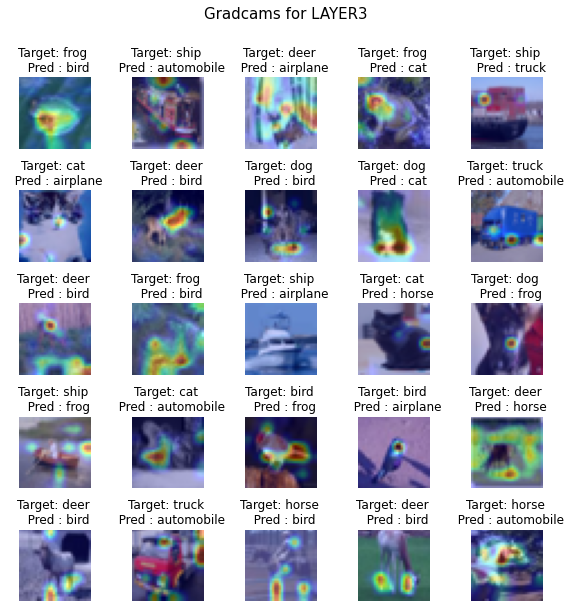

<Figure size 432x288 with 0 Axes>

In [33]:
one_batch = next(iter(test_dl))[0]
batch_imgs = []

for i in range(len(one_batch)):
    if i < 25:
        batch_imgs.append(one_batch[i])

grad_cam = GradCAMView(
    model, ['layer3'],
    device, mean, std, heatmap_alpha=0.5
)
image = batch_imgs
grad_cam(misclassified_imgs, trainset.class_to_idx, 'grad_cam', (8,8))

**Misclassified Images**

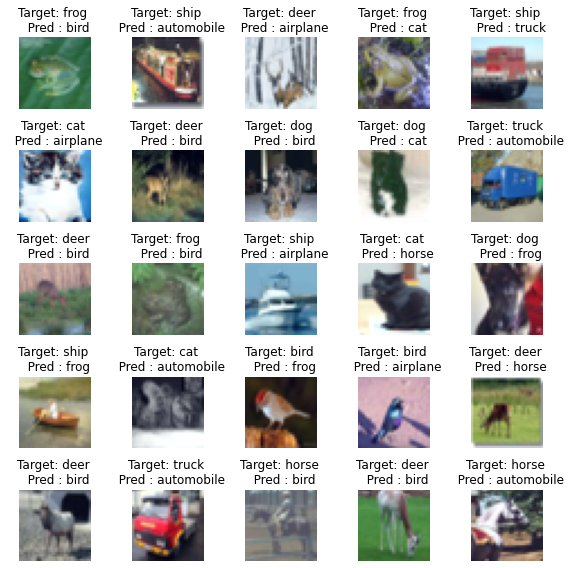

In [34]:
class_idx = trainset.class_to_idx
utils.plot_incorrect_images(misclassified_imgs, class_idx, plot_size=(8, 8))


**Validation Plots**

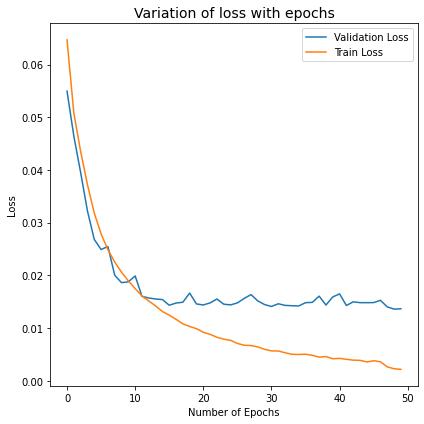

In [35]:
utils.plot_metrics([{'metric':test_loss, 'label':'Validation Loss'},
                    {'metric':train_losses, 'label':'Train Loss'}], "Loss")

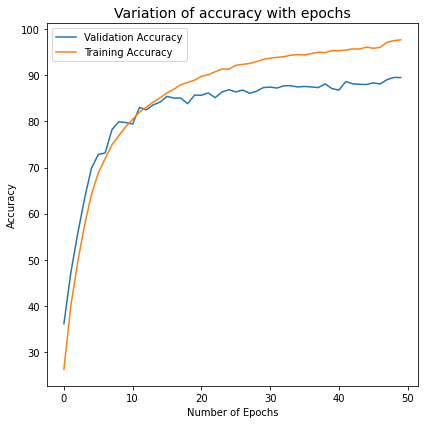

In [36]:
utils.plot_metrics([{'metric':test_accuracy, 'label':'Validation Accuracy'},
                    {'metric':train_accuracy, 'label':'Training Accuracy'}], "Accuracy")